## Importing libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers
import random
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("comments.csv")

In [ ]:
df

,comments,target
0,This guy actually puts in a lot of effort in h...,s
1,"I've learnt HTML, CSS, Javascript and Python a...",s
2,Watched this video one year ago to start my co...,s
3,His teaching is the most effective I've found ...,s
4,"I finally finished the whole 4 hours, and now ...",p
...,...,...
2474,Who are those 9 fools disliked the video.,q
2475,Anyone from karnataka??,q
2476,6th person to comment,o
2477,Things,o


In [ ]:
for i in range(len(df)):
  if df['target'][i] == 's':
    df['target'][i] = 'suggestion'
  elif df['target'][i] == 'p':
    df['target'][i] = 'positive'
  elif df['target'][i] == 'o':
    df['target'][i] = 'other'
  elif df['target'][i] == 'q':
    df['target'][i] = 'question'

In [ ]:
df.head()

,comments,target
0,This guy actually puts in a lot of effort in h...,suggestion
1,"I've learnt HTML, CSS, Javascript and Python a...",suggestion
2,Watched this video one year ago to start my co...,suggestion
3,His teaching is the most effective I've found ...,suggestion
4,"I finally finished the whole 4 hours, and now ...",positive


In [ ]:
df.shape

(2479, 2)

In [ ]:
# Checking for null values
df.isnull().sum()

comments    0
target      4
dtype: int64

### Preprocessing data

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['target'].value_counts()

positive      1050
other          568
question       448
suggestion     409
Name: target, dtype: int64

In [ ]:
# preprocessing sentence for model (replacing special characters with " ")
df['comments'] = df['comments'].str.replace("[^a-zA-Z?!#]", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
X = df['comments']
y = df['target']

## Splitting dataset into training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, stratify=y,random_state=42)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

positive      945
other         511
question      403
suggestion    368
Name: target, dtype: int64
positive      105
other          57
question       45
suggestion     41
Name: target, dtype: int64


In [ ]:
X_train

511     One of the best learning videos youTube has to...
926     This video is so well explained you are a grea...
1177    What s the difference between a void function ...
2247       Contents                 Introduction      ...
325     When you re using this video to get ready for ...
                              ...                        
788     why do you have to put the actual characterAge...
698                 LMAO I love the subtle Lost reference
1382    i like how you are not from  Yes Ok This Is  i...
662     can someone explain my question? when i write ...
900     I m paying         to get a piece of paper fro...
Name: comments, Length: 2227, dtype: object

In [ ]:
train_sentences = X_train.to_list()
test_sentences = X_test.to_list()

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train.to_numpy())
test_label_encoded = label_encoder.transform(y_test.to_numpy())

# check what training labels look like
train_labels_encoded

array([1, 2, 2, ..., 0, 2, 3])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(4, array(['other', 'positive', 'question', 'suggestion'], dtype=object))

## Preparing our data (the text) for deep sequence models

In [ ]:
# how long is each sentence on average ?
sent_lens = [len(sentences.split()) for sentences in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

20.222721149528514

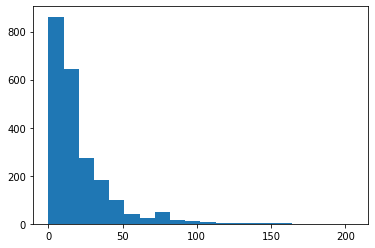

In [ ]:
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

66

In [ ]:
max(sent_lens)

205

### Create text vectorization layer


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(output_sequence_length = output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
It really helpful for the beginners and also your was of teaching is clear and easy understanding   complete course in  hrs   very good video  

Length of text: 24

Vectorized text: [[ 12  55 160  10   3 248   7  83  38  33  14 148   9 269   7 122 445 423
   34  11 415  40  44  17   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
yt_comments_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(yt_comments_text_vocab)}")
print(f"Most common words in the vocab: {yt_comments_text_vocab[:5]}")
print(f"Least common words in the vocab: {yt_comments_text_vocab[-5:]}")

Number of words in vocab: 3686
Most common words in the vocab: ['', '[UNK]', 'i', 'the', 'a']
Least common words in the vocab: ['absolutly', 'absence', 'abrupt', 'abilities', 'aayaaa']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': None,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 66,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(yt_comments_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 It really helpful for the beginners and also your was of teaching is clear and easy understanding   complete course in  hrs   very good video  

Sentence after vectorization (before embedding):
 [[ 12  55 160  10   3 248   7  83  38  33  14 148   9 269   7 122 445 423
   34  11 415  40  44  17   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]

Sentence after embedding:
 [[[ 0.02220521  0.0134549  -0.03109433 ...  0.02309856 -0.01654689
   -0.01330895]
  [-0.02845904 -0.04346836 -0.02676729 ...  0.0451183   0.02641101
    0.01634811]
  [ 0.04154173 -0.04262378 -0.02930465 ...  0.02176586 -0.01926681
    0.03549201]
  ...
  [ 0.01840165 -0.02561086  0.00607913 ... -0.0257646   0.00173355
   -0.04851706]
  [ 0.01840165 -0.02561086  0.00607913 ... -0.0257646   0.00173355
   -0.04851706]
  [ 0.01840165 -0.02561086  0.00607913 ... -0.0257

## Creating Datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

## Model Building : Feature extraction with pretrained token embedding

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 it is          and code blocks is no longer working for mac    that s unfortunate  I prefer VIM but I thought I d try CB 
Setence after embedding:
[ 0.02048647 -0.00761794  0.02260171 -0.02575849 -0.03534763 -0.00565519
 -0.05102475 -0.05365266  0.07072992  0.06406253 -0.06569648 -0.04128966
 -0.01253575  0.04951774 -0.07219057  0.0910299  -0.02749743  0.02205029
  0.04459465  0.01875841  0.07566796 -0.00470361 -0.0082244   0.02395441
 -0.03056512 -0.03030666 -0.00951284  0.0226314   0.01484695 -0.0298853 ]

Length of sentence embedding: 512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(64, activation='relu')(pretrained_embedding)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(32, activation='relu')(x)
# x = layers.Dense(16, activation='relu')(x)
# x = layers.Dense(8, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                                  verbose = 1, patience = 2)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.00001)


model.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                     

In [ ]:
history = model.fit(train_dataset,
                              epochs=50,
                              validation_data=test_dataset,
                              callbacks = [early_stopping,reduce_lr])

Epoch 1/50
70/70 [==============================] - 5s 23ms/step - loss: 1.3821 - accuracy: 0.2968 - val_loss: 1.3679 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 1.3609 - accuracy: 0.4540 - val_loss: 1.3391 - val_accuracy: 0.4919 - lr: 1.0000e-04
Epoch 3/50
70/70 [==============================] - 1s 15ms/step - loss: 1.3217 - accuracy: 0.4742 - val_loss: 1.2814 - val_accuracy: 0.4879 - lr: 1.0000e-04
Epoch 4/50
70/70 [==============================] - 1s 14ms/step - loss: 1.2452 - accuracy: 0.4885 - val_loss: 1.1829 - val_accuracy: 0.4960 - lr: 1.0000e-04
Epoch 5/50
70/70 [==============================] - 1s 15ms/step - loss: 1.1440 - accuracy: 0.5128 - val_loss: 1.0837 - val_accuracy: 0.5161 - lr: 1.0000e-04
Epoch 6/50
70/70 [==============================] - 1s 15ms/step - loss: 1.0693 - accuracy: 0.5370 - val_loss: 1.0075 - val_accuracy: 0.5726 - lr: 1.0000e-04
Epoch 7/50
70/70 [==============================] - 

In [ ]:
preds = model.predict(test_sentences)

preds = tf.argmax(preds, axis=1)
preds

<tf.Tensor: shape=(248,), dtype=int64, numpy=
array([2, 1, 0, 1, 3, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       0, 0, 1, 2, 0, 3, 2, 3, 0, 3, 0, 0, 3, 3, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 3, 0, 1, 2, 1, 3, 0, 1, 2, 2, 0, 0, 2, 3, 1, 0, 3, 2, 0,
       1, 1, 0, 1, 1, 2, 0, 2, 3, 0, 2, 0, 3, 1, 1, 2, 1, 3, 0, 3, 1, 1,
       2, 2, 1, 1, 1, 3, 1, 0, 0, 2, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 2, 1,
       2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       3, 1, 0, 1, 1, 3, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 3,
       0, 0, 1, 1, 2, 3, 0, 3, 3, 1, 2, 1, 3, 1, 1, 1, 0, 1, 1, 2, 1, 2,
       3, 1, 1, 3, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2,
       2, 1, 1, 1, 3, 1, 3, 0, 1, 0, 3, 1, 2, 2, 1, 1, 3, 0, 1, 1, 2, 0,
       1, 2, 2, 1, 3, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 3, 1, 0, 0, 1, 3,
       1, 1, 2, 1, 1, 0])>

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_label_encoded,preds)

0.7580645161290323

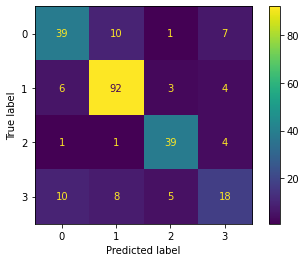

In [ ]:
matrix = confusion_matrix(y_true=test_label_encoded, y_pred=preds)

p = ConfusionMatrixDisplay(matrix)
p.plot();

## Saving the model

In [ ]:
model.save('/content/drive/MyDrive/model/model')

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/model/model.h5")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/model/assets


Saved model to disk
